# Part I: Profiling expression STRs across 17 human tissues

This notebook contains info for:

#### Figures
* **Figure 1D** causal examples

#### Supplementary Tables:
* **Supplementary Table LITERATURE**

In [1]:
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-calling"
FIGPREFIX = "SuppFig"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = COLORS.keys()

############ Load linear regression data #############
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(DATADIR, "%s_LinearRegression.tab"%t), sep="\t", usecols=[0,1,3,8,11])
    data[t]["str.start"] = (data[t]["str.start"]).apply(int)

Populating the interactive namespace from numpy and matplotlib


In [15]:
# Get best tissue for a given eSTR
PTHRESH = 1 # print all
def GetBestTissue(chrom, start, gene, data):
    """
    Return tissue, pval, beta
    """
    best_tissue = None
    best_p = 1
    best_beta = None
    for t in data:
        x = data[t]
        x = x[(x["chrom"]==chrom) & (x["str.start"]==start) & (x["gene"]==gene)]
        if x.shape[0] == 0: continue
        if x["p.wald"].values[0] <= best_p:
            best_tissue = t
            best_p = x["p.wald"].values[0]
            best_beta = x["beta"].values[0]
        if  x["p.wald"].values[0] < PTHRESH:
            print("%s %s %s"%(t, x["p.wald"].values[0], x["beta"].values[0]))
    return best_tissue, best_p, best_beta

def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
def PlotESTR(gene, tissue, chrom, start, end, COLORS, fname=None):
    ExtractData(gene, chrom, start, tissue)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    
    rmgts = []
    for gt in sorted(list(set(data["str"]))):
        if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    data = data[data["str"].apply(lambda x: x not in rmgts)]

    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    
    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    means["num"] = range(means.shape[0])
    
    ax.plot(means["num"], means["expr"], color="black", marker="o")
    ax.set_xlabel("Allele length (bp)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item)+(end-start+2)*2 for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.suptitle("");
    plt.show()
    if fname is not None: fig.savefig(fname)

# CSTB

https://www.ncbi.nlm.nih.gov/pubmed/9126745
repeat involved in EPM1 (progressive myoclonus epilepsy MIM 254800)
mutant alleles contain 60+ copies. normal alleles 2-3 copies

https://www.ncbi.nlm.nih.gov/pubmed/22573514
CSTB causal eQTL. Figure 1B. more repeats = more expression

https://www.ncbi.nlm.nih.gov/pubmed/10441345
propose here the mechanism is altered spacing

Adipose-Visceral 2.4937880117961275e-06 0.33822105996552443
Heart-LeftVentricle 1.630030072311266e-11 0.4614220913424358
Artery-Tibial 2.2954051577385685e-15 0.4581644098671728
Cells-Transformedfibroblasts 1.4904429779250703e-18 0.5521154466758411
Nerve-Tibial 7.331667966724233e-14 0.4451180552487229
Muscle-Skeletal 1.286148195159528e-21 0.4904589924356517
WholeBlood 2.1014922735574548e-14 0.4070895467591639
Esophagus-Muscularis 2.7563910296998874e-09 0.4020328183061333
Skin-SunExposed 1.8756893481002583e-14 0.4296000313279473
Adipose-Subcutaneous 0.0001891850722444315 0.2290882993859059
Thyroid 4.1322697025400756e-16 0.4801373588533952
Skin-NotSunExposed 6.339980281606235e-07 0.3419327648502498
Artery-Aorta 1.9626488165263646e-05 0.30828105920092885


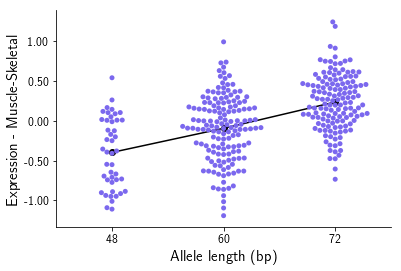

In [3]:
chrom = "chr21"
start = 45196326
end = 45196360
gene = "ENSG00000160213.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CSTB.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PIG3 (TP53I3)

https://www.nature.com/articles/ng836
number of repeats positively correlated with expression, only in the presence of p53 (Figure 5b)

Muscle-Skeletal 0.006844134473106718 0.15480586780044353
Esophagus-Mucosa 0.008148316941980148 0.1763826888243387
Thyroid 0.0006043215012692471 0.2216459057733232


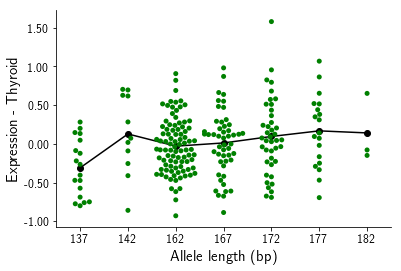

In [4]:
chrom = "chr2"
start = 24307211
end = 24307290
gene = "ENSG00000115129.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PIG3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# MMP9

https://www.ncbi.nlm.nih.gov/pubmed/10428474
polyCA, esophageal carcinoma cell lines
longer repeat = more expression
Figure 3
range tested 0-21 repeats
most Japanese had 20, 21, or 22 repeats

Skin-SunExposed 0.003908333059473693 0.18187989470752275


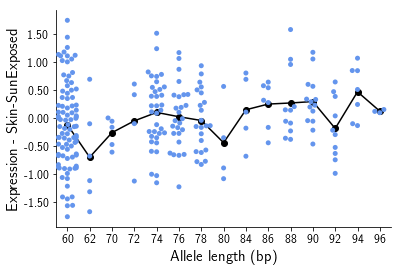

In [5]:
chrom = "chr20"
start = 44637412
end = 44637458
gene = "ENSG00000100985.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MMP9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# EGFR

http://www.jbc.org/content/274/19/13176.long
Figure 4A
16-21 in vivo nonlinear (16 and 20 highest; various cell lines have different numbers)
16-21 in vitro show decreasing trend with expression

Heart-LeftVentricle 0.007359973711983423 -0.20856936945691976
Muscle-Skeletal 0.006974538202550474 0.15839261663021156
Esophagus-Mucosa 0.0017561588027997658 0.21266338120795727


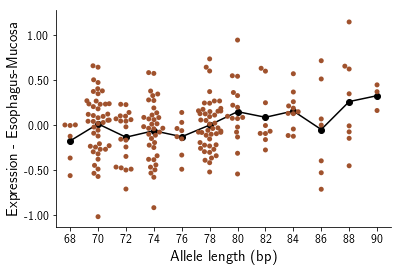

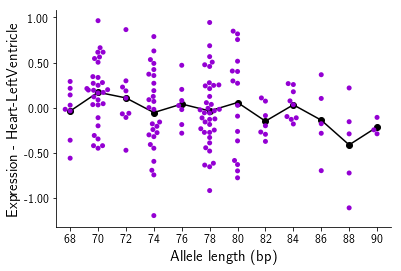

In [6]:
chrom="chr7"
start = 55088253
end = 55088286
gene = "ENSG00000146648.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EGFR.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)
PlotESTR(gene, "Heart-LeftVentricle", chrom, start, end, COLORS)

# IFNG

https://www.ncbi.nlm.nih.gov/pubmed/15900487

CA12 and CA15 with decreased and increased expression

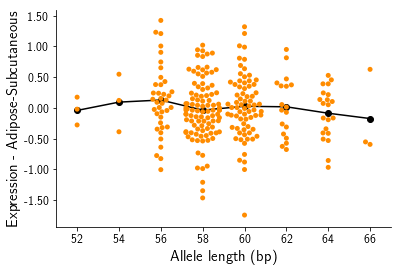

In [7]:
chrom="chr12"
start = 68552495
end = 68552523
gene = "ENSG00000111537.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IFNG.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# UGT1A1
https://www.ncbi.nlm.nih.gov/pubmed/7565971
human hepatoma
longer repeat = reduced expression

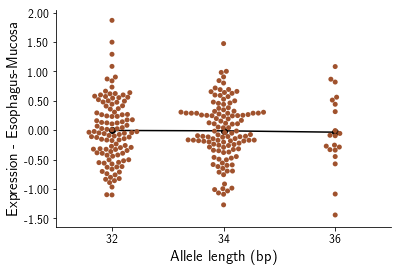

In [8]:
chrom="chr2"
start = 234668880
end = 234668894
gene = "ENSG00000241635.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_Gilbert.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# NOP56

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3135815/
expansion causes SCA36

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5504081/
reduced expression in ipscs of patients (bit expansions)

Artery-Tibial 9.530137450101992e-05 0.2369619492780936
Muscle-Skeletal 7.763973061996127e-12 0.3639638161260791
Skin-SunExposed 5.980036839593017e-05 0.2342239733210593
Adipose-Subcutaneous 0.0010882684400698 0.2003387759679452
Thyroid 2.4089756567925805e-08 0.3399550374134861
Skin-NotSunExposed 0.003983216894907949 0.20176436491436384


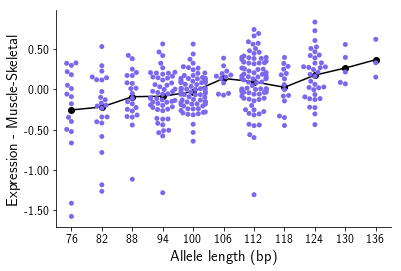

In [9]:
chrom="chr20"
start=2633379
end = 2633421
gene = "ENSG00000101361.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NOP56.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VLDLR

WholeBlood 8.626591585226099e-14 -0.3958859573307789


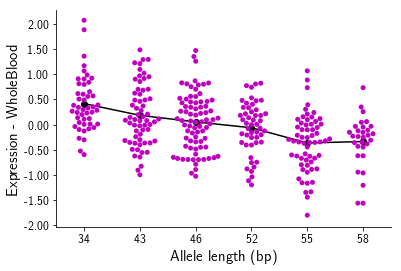

In [11]:
gene = "ENSG00000147852.11"
chrom = "chr9"
start = 2622147
end = 2622171

best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VLDLR.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# Jacobsen Syndrome

In [ ]:
gene = "ENSG00000110395.4"
chrom = "chr11"
start = 119077000
end = 119077033
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CBL.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# ALOX5


In [ ]:
gene = "ENSG00000012779.6"
chrom = "chr10"
start = 45869548
end = 45869585
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ALOX5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotESTR(gene, "Skin-SunExposed", chrom, start, end, COLORS)

# Below are additional examples where expression is not directly tested

# SCNA
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6054541/

repeat length pos relationship with expression
increases binding of nearby TF sites
don't directly test expression

In [ ]:
chrom = "chr4"
start = 90636808
end = 90636841
gene = "ENSG00000145335.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SNCA.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# MED19
SCZ GWAS

Adipose-Visceral 3.3148010278500404e-06 0.3368927107214041
Brain-Cerebellum 0.001094820593753201 0.3218102727074496
Lung 2.317680069611306e-05 0.2662823032204029
Brain-Caudate 0.04129265601615899 0.20446742173096602
Heart-LeftVentricle 0.4152468812784164 0.05928656493563196
Artery-Tibial 4.24800374243584e-06 0.2808033233289799
Cells-Transformedfibroblasts 0.0031928696792304346 0.2011447570096183
Nerve-Tibial 0.006461190967527226 0.17391090281358682
Muscle-Skeletal 3.076008055024236e-06 0.2570274444414629
Esophagus-Mucosa 0.0009307086562075193 0.21064297957710576
WholeBlood 6.7522373268889225e-06 0.25095034233973673
Esophagus-Muscularis 7.660486142644615e-06 0.3097394722752356
Skin-SunExposed 2.222394868570618e-08 0.3243412364155367
Adipose-Subcutaneous 1.2963494023108917e-12 0.4274209626958312
Thyroid 3.56528538544888e-06 0.289474257550456
Skin-NotSunExposed 3.105393422347143e-07 0.3557436264552488
Artery-Aorta 0.04579884163988646 0.14824781748620247


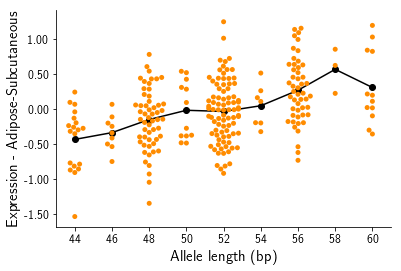

In [21]:
chrom = "chr11"
start = 57523883
end = 57523905
gene = "ENSG00000156603.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MED19.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# APH1A
asd gwas

In [ ]:
chrom = "chr1"
start = 150314982
end = 150315002
gene = "ENSG00000117362.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_APH1A.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CTNNAL1
SCZ

In [ ]:
chrom = "chr9"
start = 111783775
end = 111783810
gene = "ENSG00000119326.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CTNNAL1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ATHL1
multiple gwas hits

In [ ]:
chrom = "chr11"
start = 297578
end = 297600
gene = "ENSG00000142102.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ATHL1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RPUSD3
skin pigmentation gwas


In [ ]:
chrom = "chr3"
start = 9883164
end = 9883184
gene = "ENSG00000156990.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RPUSD3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VWA7
   BLOOD PROTEIN GWAS

In [ ]:
chrom = "chr6"
start = 31699087
end = 31699098
gene = "ENSG00000204396.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VWA7.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# DHRS4
bipolar

In [ ]:
chrom = "chr14"
start = 24392239
end = 24392263
gene = "ENSG00000157326.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DHRS4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# IFT74
scz gwas

In [ ]:
chrom = "chr9"
start = 26979150
end = 26979161
gene = "ENSG00000096872.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IFT74.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PRR12
gwas scz

In [ ]:
chrom = "chr19"
start = 50110619
end = 50110638
gene = "ENSG00000126464.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PRR12.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ARPP19
gwas scz

In [ ]:
chrom = "chr15"
start = 52854833
end = 52854847
gene = "ENSG00000128989.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ARPP19.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VSIG2
gwas scz

In [ ]:
chrom = "chr11"
start = 124621018
end = 124621035
gene = "ENSG00000019102.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VSIG2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# FKBPL
scz gwas

In [ ]:
chrom = "chr6"
start = 32066234
end = 32066274
gene = "ENSG00000204315.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FKBPL.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# DCLK3
autism gwas

In [ ]:
chrom = "chr3"
start = 36835922
end = 36835957
gene = "ENSG00000163673.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DCLK3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# EXOG
scz gwas

In [ ]:
chrom = "chr3"
start = 38476818
end = 38476838
gene = "ENSG00000157036.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EXOG.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GLS
blood gwas

In [ ]:
chrom = "chr2"
start = 191745599
end = 191745646
gene = "ENSG00000115419.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GLS.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PCSK9
gwas ldl

In [ ]:
chrom = "chr1"
start = 55505553
end = 55505575
gene = "ENSG00000169174.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PCSK9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ASCC2
gwas
bipolar

In [ ]:
chrom = "chr22"
start = 30234193
end = 30234217
gene = "ENSG00000100325.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ASCC2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# TMEM158
gwas scz

In [ ]:
chrom = "chr3"
start = 45297762
end = 45297782
gene = "ENSG00000249992.1"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TMEM158.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CCDC137
gwas cholesterol

In [ ]:
chrom = "chr17"
start = 79667664
end = 79667695
gene = "ENSG00000185298.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CCDC137.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# L1TD1
gwas pediatric bone

In [ ]:
chrom = "chr1"
start = 62650593
end = 62650617
gene = "ENSG00000240563.1"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_L1TD1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# FAM154B
cognitive ability gwas

In [ ]:
chrom = "chr15"
start = 82475166
end = 82475177
gene = "ENSG00000188659.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FAM154B.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# NRBP2
SCZ gwas

In [ ]:
chrom = "chr8"
start = 144839147
end = 144839158
gene = "ENSG00000185189.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NRBP1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# NLRX1
platelet count


In [ ]:
chrom = "chr11"
start = 119077000
end = 119077000
gene = "ENSG00000160703.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NLRX1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SLC36A1
basophil perc gwas

In [ ]:
chrom = "chr5"
start = 150848654
end = 150848654
gene = "ENSG00000123643.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SLC36A1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SIGLEC5
blood protein gwas

In [ ]:
chrom = "chr19"
start = 52130149
end = 52130149
gene = "ENSG00000105501.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SIGLEC5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GPD1L
scz gwas

In [ ]:
chrom = "chr3"
start = 32083114
end = 32083114
gene = "ENSG00000152642.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GPD1L.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SERINC2
heart rate https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5832790/

In [ ]:
chrom = "chr1"
start = 31886001
end = 31886001
gene = "ENSG00000168528.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SERINC2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# IRF5
autoimmune gwas

In [ ]:
chrom = "chr7"
start = 128577915
end = 128577915
gene = "ENSG00000128604.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IRF5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CARD9
gwas

In [ ]:
chrom = "chr9"
start = 139258185
end = 139258185
gene = "ENSG00000187796.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CARD9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# IGSF9B
gwas scz/asd

In [ ]:
chrom = "chr11"
start = 133820762
end = 133820762
gene = "ENSG00000080854.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IGSF9B.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RASIP1
crohn's disease gwas

In [ ]:
chrom = "chr19"
start = 49232030
end = 49232030
gene = "ENSG00000105538.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RASIP1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# MKRN2
cholesterol gwas

In [ ]:
chrom = "chr3"
start = 12625265
end = 12625265
gene = "ENSG00000075975.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MKRN2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CCDC137,OXLD1
cholesterol

In [ ]:
chrom = "chr17"
start = 79667664
end = 79667664
gene = "ENSG00000185298.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CCDC137.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# LCAT
cholesterol gwas

In [ ]:
chrom = "chr16"
start = 68014740
end = 68014740
gene = "ENSG00000213398.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_LCAT.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# NPRL3
blood gwas

In [ ]:
chrom = "chr16"
start = 186525
end = 186525
gene = "ENSG00000103148.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NPRL3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PAX8

In [ ]:
chrom = "chr2"
start = 113984226
end = 113984226
gene = "ENSG00000125618.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PAX8.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RASGRP3

In [ ]:
chrom = "chr2"
start = 33762260
end = 33762260
gene = "ENSG00000152689.13"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RASGRP3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VGLL2

In [ ]:
chrom = "chr6"
start = 117524057
end = 117524057
gene = "ENSG00000170162.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VGLL2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# TMPRSS9

In [ ]:
chrom = "chr19"
start = 2421294
end = 2421294
gene = "ENSG00000178297.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TMPRSS9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# HTATIP2

In [ ]:
chrom = "chr11"
start = 20384871
end = 20384871
gene = "ENSG00000109854.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_HTATIP2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SMYD4
Blood_protein_levels

In [ ]:
chrom = "chr17"
start = 1682774
end = 1682774
gene = "ENSG00000186532.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SMYD4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# EXOC3

In [ ]:
chrom = "chr5"
start = 443336
end = 443336
gene = "ENSG00000180104.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EXOC3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ESR2

In [ ]:
chrom = "chr14"
start = 64724929
end = 64724929
gene = "ENSG00000140009.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ESR2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PRR12

In [ ]:
chrom = "chr19"
start = 50083547
end = 50083547
gene = "ENSG00000126464.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PRR12.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GALNT2

Adipose-Visceral 0.3263989740721012 -0.07376957071507781
Brain-Cerebellum 0.19447222402646028 0.13083262710290136
Lung 0.6208309563217858 -0.032294827653768
Brain-Caudate 0.5237995055371011 -0.06384426876947281
Heart-LeftVentricle 0.1102442725096104 -0.11911343591316405
Artery-Tibial 0.5337043945335175 -0.03930703535681316
Cells-Transformedfibroblasts 0.9993623266633458 5.508477498962234e-05
Nerve-Tibial 0.8328975290703955 0.01354812288612858
Muscle-Skeletal 0.3335580872814752 0.05439914997200503
Esophagus-Mucosa 0.3215417676194477 -0.0646659751159428
WholeBlood 0.6243527857001234 -0.02752025464788444
Esophagus-Muscularis 0.8963425584864483 -0.009246926291647434
Skin-SunExposed 0.4591639166900192 -0.04473698911494672
Adipose-Subcutaneous 0.4618849893948444 -0.046553987924852935
Thyroid 0.6847250054197697 -0.026068826651523325
Skin-NotSunExposed 0.16214256725474807 -0.10102181125187083
Artery-Aorta 2.248764404534748e-05 -0.3162409020210092


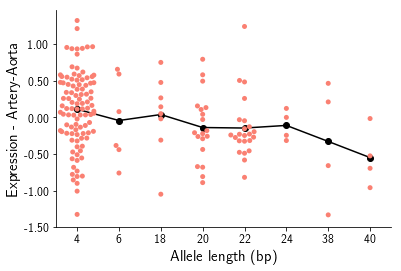

In [18]:
chrom = "chr1"
start = 230264005
end = 230264005
gene = "ENSG00000143641.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GALNT2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# DYNC1I2

Adipose-Visceral 0.611084565620134 0.040375709891372825
Brain-Cerebellum 0.5761463294401072 0.06005167713016209
Lung 0.5324548690495807 -0.0419265493534224
Brain-Caudate 0.8725622728595891 0.01649941740845047
Heart-LeftVentricle 0.1332313999632158 0.1156247569994032
Artery-Tibial 3.285116865273006e-08 0.3486973070754483
Cells-Transformedfibroblasts 4.728571087784242e-10 0.42717431008843015
Nerve-Tibial 0.6711244675116462 0.02796175544124473
Muscle-Skeletal 6.018307269298608e-09 0.3288892522422259
Esophagus-Mucosa 0.2980283017277572 0.07096611353515525
WholeBlood 0.07994553844143218 0.10263911283336544
Esophagus-Muscularis 0.09241344263142252 0.12442318009480735
Skin-SunExposed 2.311543694505057e-07 0.3158839748017045
Adipose-Subcutaneous 5.164733520088451e-12 0.4320369747763089
Thyroid 0.00971115122952232 0.173611268475875
Skin-NotSunExposed 0.07997432555733408 0.1323360653089339
Artery-Aorta 0.1412186353820039 0.11538521114606415


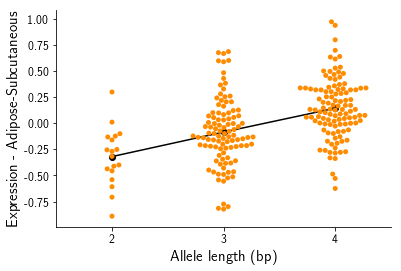

In [19]:
chrom = "chr2"
start = 172569135
end = 172569135
gene = "ENSG00000077380.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DYNC1I2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RFT1

Adipose-Visceral 5.850854394005191e-07 0.3752071146637285
Brain-Cerebellum 1.470869320238301e-11 0.6398862587357226
Lung 5.290932317579176e-06 0.2995390615130402
Brain-Caudate 8.380816504635875e-06 0.44375591538527176
Heart-LeftVentricle 8.799082046513962e-10 0.4482563202113437
Artery-Tibial 1.875830650265948e-24 0.5938224449716818
Cells-Transformedfibroblasts 7.256750372254043e-08 0.3785117874774329
Nerve-Tibial 3.185315539057736e-13 0.4535620263880949
Muscle-Skeletal 2.0871598717681136e-07 0.29524050486348385
Esophagus-Mucosa 2.7123554598485613e-08 0.3639331498775384
WholeBlood 6.086498722325403e-05 0.2335903505366913
Esophagus-Muscularis 1.7994635063290856e-24 0.6582648642457852
Skin-SunExposed 1.7311089574216045e-06 0.292078775090833
Adipose-Subcutaneous 1.0164963568144208e-15 0.4900285753865905
Thyroid 5.520449095903695e-20 0.5591089474995059
Skin-NotSunExposed 5.068441036499481e-07 0.3621578032579121
Artery-Aorta 5.169004081157927e-20 0.6248445779828318


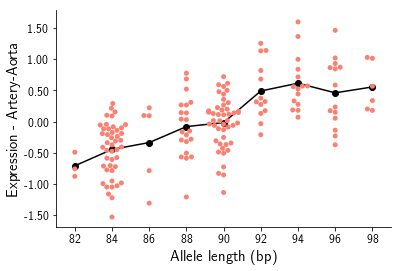

In [22]:
chrom = "chr3"
start = 53128363
end = 53128413
gene = "ENSG00000163933.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
best_tissue = "Artery-Aorta"
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RFT1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# FADS1

Adipose-Visceral 0.022140260266841832 0.1686097369213846
Brain-Cerebellum 5.7179943215555834e-08 0.5018644628118429
Lung 0.14544722036271995 0.09233897516392237
Brain-Caudate 0.06839356423631274 0.18029272520386647
Heart-LeftVentricle 0.04829331778008908 0.14197928889766734
Artery-Tibial 0.0914904245068748 0.10407545577163256
Cells-Transformedfibroblasts 0.0987856771491434 0.11287947094086355
Nerve-Tibial 0.0321554426298863 0.13555517990184604
Muscle-Skeletal 0.0015721797417056235 0.17205832833358378
Esophagus-Mucosa 4.44064994823136e-05 0.2572549521080461
WholeBlood 0.1907882729736566 -0.07275281052858977
Esophagus-Muscularis 0.13376718910219745 0.10431019360532012
Skin-SunExposed 0.20508428530197315 0.07489119045195676
Adipose-Subcutaneous 0.06221445898243271 0.11604036914177401
Thyroid 3.080488549773928e-05 0.25880810528416803
Skin-NotSunExposed 0.9376491442561544 -0.005580328061488744
Artery-Aorta 0.4791879442462795 0.05220094153936519


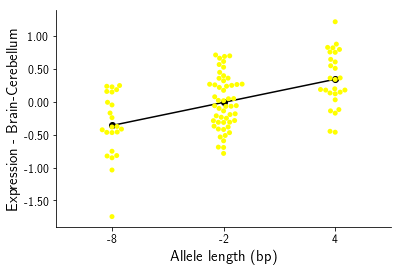

In [20]:
chrom = "chr11"
start = 61620629
end = 61620629
gene = "ENSG00000149485.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FADS1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GNL3

In [ ]:
chrom = "chr3"
start = 52801574
end = 52801574
gene = "ENSG00000163938.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GNL3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PLCD4
test height neg example?

Adipose-Visceral 0.6849975987665897 0.031524388972718496
Brain-Cerebellum 0.6898208083544703 0.042404228789292085
Lung 0.016588160268224454 0.16101316205747312
Brain-Caudate 0.26919261724381066 -0.11575516396959484
Heart-LeftVentricle 0.6314886166695293 0.03772825590932579
Artery-Tibial 0.9584132123263664 0.003383596451327036
Cells-Transformedfibroblasts 0.012430725503004976 0.1805662277201721
Nerve-Tibial 0.009175029527481737 0.17183162681121975
Muscle-Skeletal 0.00012185985999398356 -0.22411052932943235
Esophagus-Mucosa 0.1836874928771977 0.09017128989031543
WholeBlood 0.3921988762571175 0.050606636365236365
Esophagus-Muscularis 0.5674174521643125 0.04254541956915038
Skin-SunExposed 0.7963331305562367 -0.016338639324738315
Adipose-Subcutaneous 0.3230834066546093 0.06573174387189001
Thyroid 0.4254245144064428 0.054254887339942416
Skin-NotSunExposed 0.25919753175348204 -0.08501465065894523
Artery-Aorta 0.011508292041182677 0.1962914936361929


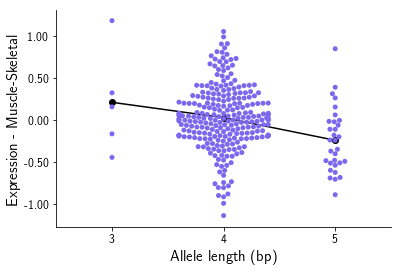

In [17]:
chrom = "chr2"
start = 219467421
end = 219467421
gene = "ENSG00000115556.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PLCD4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CEBPZ

Adipose-Visceral 0.005152944691365993 -0.21118879456063275
Brain-Cerebellum 0.6207707576375256 -0.04907896671269868
Lung 5.7404538521840735e-05 -0.2577252716730837
Brain-Caudate 0.0227186874430438 -0.2288202823329367
Heart-LeftVentricle 0.3953424247501488 0.06373250488055479
Artery-Tibial 0.00031024650327008264 -0.2262693834558508
Cells-Transformedfibroblasts 0.00014790364405058037 -0.2651593139985078
Nerve-Tibial 7.675558783387976e-11 -0.4002454852071802
Muscle-Skeletal 7.634216177036411e-05 -0.2199626526590477
Esophagus-Mucosa 1.3789876982818994e-10 -0.40533872368481255
WholeBlood 0.5507266043372111 -0.034183341888623785
Esophagus-Muscularis 0.001297600002865209 -0.22874794547949984
Skin-SunExposed 4.552258827819654e-06 -0.2729273636563662
Adipose-Subcutaneous 2.996650452998621e-07 -0.3209384966324213
Thyroid 1.650636062567542e-05 -0.2735847636897349
Skin-NotSunExposed 7.635462398082737e-05 -0.2829474801667376
Artery-Aorta 9.739697266537375e-09 -0.4155569420853405


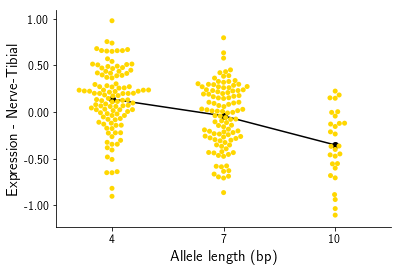

In [23]:
chrom = "chr2"
start = 37551759
end = 37551759
gene = "ENSG00000115816.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CEBPZ.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# TM6SF2

Adipose-Visceral 5.208529684822029e-05 -0.2944533864233743
Brain-Cerebellum 5.736921723771967e-06 -0.4341484269889436
Lung 4.754623321320968e-07 0.3138876039042868
Brain-Caudate 0.13603122516764787 -0.14935934573109272
Heart-LeftVentricle 1.579739874092554e-05 -0.30839230516502025
Artery-Tibial 0.013046984533969736 -0.15290367740215935
Cells-Transformedfibroblasts 9.750301732727742e-08 -0.3546058014453732
Nerve-Tibial 9.136655068840051e-07 -0.3046124231197131
Muscle-Skeletal 0.0706812309707841 -0.10055176156912038
Esophagus-Mucosa 0.4625383399358166 -0.04724900505058766
Esophagus-Muscularis 0.014418586382488106 0.17108700166067434
Skin-SunExposed 0.0031304493747798304 -0.17566878854563725
Adipose-Subcutaneous 0.00015935651533460462 -0.2325307825819341
Thyroid 4.653570528143676e-08 -0.3377419364751977
Skin-NotSunExposed 0.058940775651244975 -0.1331179825670238
Artery-Aorta 0.16562726951237414 -0.10348977495904386


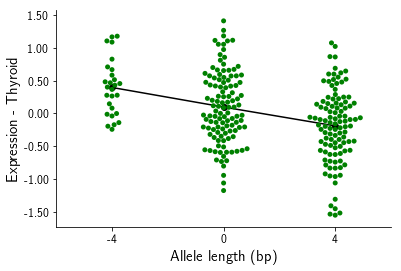

In [27]:
chrom = "chr19"
start = 19424949
end = 19424949
gene = "ENSG00000213996.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TM6SF2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# MAN2A1

Adipose-Visceral 0.9012727971020432 -0.009528266289620516
Brain-Cerebellum 0.2683484742072085 -0.11470605490991932
Lung 0.04369938485141665 -0.13142089921009506
Brain-Caudate 0.6551892389374182 -0.045913073841798886
Heart-LeftVentricle 0.8092188517038941 -0.01806936092307794
Artery-Tibial 0.1340321417238649 0.09483758394482993
Cells-Transformedfibroblasts 0.9138121819836692 -0.007605601963554734
Nerve-Tibial 0.5022507540692391 -0.04351647261460321
Muscle-Skeletal 0.13293272155927052 -0.08498416081987924
Esophagus-Mucosa 0.894454899763506 0.008719393407265349
WholeBlood 2.3903926611045725e-06 -0.26802279948460983
Esophagus-Muscularis 0.6368269694745285 0.03410822360765762
Skin-SunExposed 0.8394583850303052 -0.012294430277838764
Adipose-Subcutaneous 0.6618489376181729 -0.02762826941242814
Thyroid 0.0586166233650352 0.12148812327691658
Skin-NotSunExposed 0.6301851340433712 -0.03533925685793033
Artery-Aorta 0.8548714541353637 -0.013966087178635796


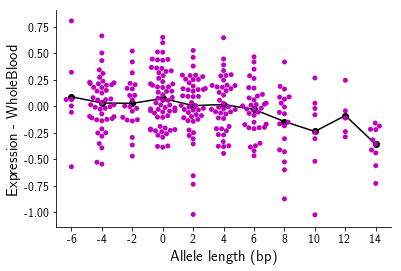

In [26]:
chrom = "chr5"
start = 109038017
end = 109038017
gene = "ENSG00000112893.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MAN2A1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)